In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
from scipy.signal import butter, filtfilt
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz
import re

In [2]:
# capacitor parameters
tf = 0.26e-6 #m
Af = 10000e-12 #m^2

In [3]:
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data_section = False
    column_data = []
    
    for line in lines:
        if "Data" in line:
            data_section = True
            continue
        
        if data_section:
            values = re.split(r'\s+', line.strip())
            if len(values) >= 8 and values[0].isdigit():  # Ensure valid data row
                column_data.append([float(v) for v in values])
    
    # Transpose the data to get lists for each column
    columns = list(map(list, zip(*column_data)))
    return columns

def find_Ec_Pr(P,E):
    #find the zero crossing points for P
    idx1 = np.where(np.abs(P[0:int(len(P)/2)]) == np.min(np.abs(P[0:int(len(P)/2)])))
    idx2 = np.where(np.abs(P[int(len(P)/2):int(len(P))]) == np.min(np.abs(P[int(len(P)/2):int(len(P))])))
    Ec1 = E[idx1[0][0]]
    Ec2 = E[int(len(E)/2)-1 + idx2[0][0]]
    #find the zero crossing points for E
    idx2 = np.where(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10]) == np.min(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10])))
    Pr1 = P[0]
    Pr2 = P[int(len(E)/2)-10 + idx2[0][0]]
    return Ec1, Ec2, Pr1, Pr2

def offset_correction(P, E):
    Ec1, Ec2, Pr1, Pr2 = find_Ec_Pr(P,E)
    return np.array(E) - (Ec1 + Ec2)/2

def Polarization_correction(P, E):
    Ec1, Ec2, Pr1, Pr2 = find_Ec_Pr(P,E)
    return np.array(P) - (Pr1 + Pr2)/2

def filter_curret(dt, I, cutoff):
    order = 4  # Order of the filter
    nyquist = 0.5/dt # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency
    print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, I)

# this method is clearly wrong
def find_R(V,I,P): 
    idx1 = np.where(np.abs(P[0:int(len(P)/2)]) == np.min(np.abs(P[0:int(len(P)/2)])))
    idx2 = np.where(np.abs(P[int(len(P)/2):int(len(P))]) == np.min(np.abs(P[int(len(P)/2):int(len(P))])))
    Vc1 = V[idx1[0][0]]
    Vc2 = V[int(len(V)/2)-1 + idx2[0][0]]
    R1 = abs(Vc1/I[idx1[0][0]])
    R2 =  abs(Vc2/I[int(len(V)/2)-1 + idx2[0][0]])
    return (R1+R2)/2

def TDGL(t, P, E, alpha, beta, rho):
    P_fit = [P[0]]
    dt = t[1] - t[0]
    for i in range(1,len(t)):
        df_dp = 2*alpha*P_fit[i-1] + 4*beta*P_fit[i-1]**3 - E[i]
        P_fit.append(P_fit[i-1] - dt/rho*df_dp)
    return P_fit

#generating sine wave
def sin_wave(M, frequency, dt):
    T = 1 / frequency  # Period of the wave
    t = np.arange(0, T, dt)  # Time values
    # Generate triangular wave: 0 → +max → -max → 0
    y =  M*np.sin(2*np.pi*t*frequency)
    return t, y

In [4]:
file_path = "C:\\Drive\\FE_SR\\doublewellsystems\\Ferroelectric_Capacitor\\Hysteresis\\"
#f_data = [1, 2, 10, 20, 100, 200, 1000]
f_data = [1, 10, 100, 1000]
#read the data

In [5]:
time = [] # s
V_drive = [] # V
V_crt = [] # V
P = [] # C/m^2
P_crt = [] # C/m^2
I = [] # A
I_flt = [] # A
dt = [] # s
E = [] # V/m

for i in range(len(f_data)):
    data_columns = extract_data(file_path+f"Hysteresis_{f_data[i]}Hz.txt")
    Time, Drive_Voltage, Measured_Polarization, Capacitance, Normalized_Capacitance, Dielectric_Constant, Instantaneous_Current = data_columns[1:]
    time.append(np.array(Time)*1e-3)
    V_drive.append(np.array(Drive_Voltage))
    P.append(np.array(Measured_Polarization)*1e-2)
    I.append(np.array(Instantaneous_Current)*1e-3)
    V_crt.append(offset_correction(P[i], V_drive[i]))
    P_crt.append(Polarization_correction(P[i], V_drive[i]))
    E.append(V_crt[i]/tf)
    dt.append((Time[1] - Time[0])*1e-3)
    I_flt.append(filter_curret(dt[i], I[i], f_data[i]*100))
    print("time data len = ", len(Time))
    print("frequency = ", 1000/Time[-1])
    print("dt (s) = ", dt[i])

    

0.0125
time data len =  16001
frequency =  1.0
dt (s) =  6.25e-05
0.013
time data len =  15385
frequency =  10.00040001600064
dt (s) =  6.5e-06
0.02
time data len =  10001
frequency =  100.0
dt (s) =  1e-06
0.1
time data len =  2001
frequency =  1000.0
dt (s) =  5e-07


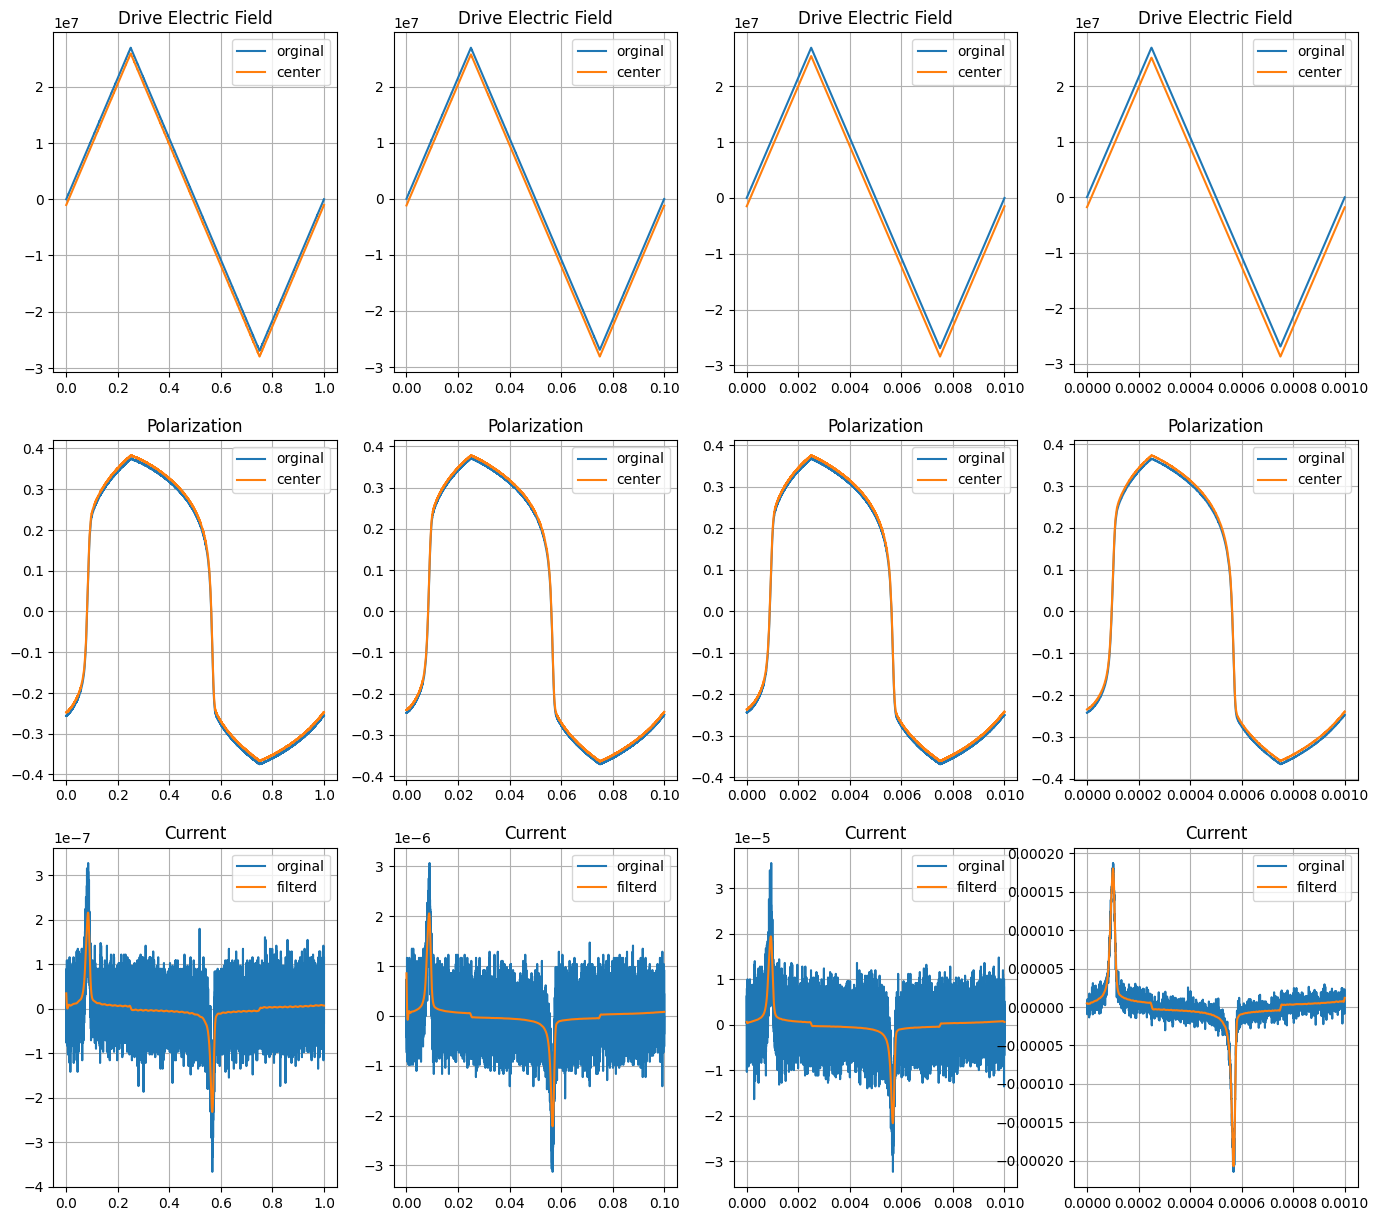

In [6]:
plt.figure(figsize=(30,15))
for i in range(len(f_data)):
    plt.subplot(3,7,i+1); plt.plot(time[i], V_drive[i]/tf, label = f"orginal"); plt.plot(time[i], E[i], label = f"center")
    plt.legend();plt.grid(); plt.title("Drive Electric Field")
    plt.subplot(3,7,7+i+1); plt.plot(time[i], P[i], label = f"orginal"); plt.plot(time[i], P_crt[i], label = f"center") 
    plt.legend();plt.grid(); plt.title("Polarization")
    plt.subplot(3,7,14+i+1); plt.plot(time[i], I[i], label = f"orginal"); plt.plot(time[i], I_flt[i], label = f"filterd")
    plt.legend();plt.grid(); plt.title("Current")
    

In [7]:
Vc = []
Pr = []
for i in range(len(f_data)):
    Vc1, Vc2, Pr1, Pr2 = find_Ec_Pr(P_crt[i], V_crt[i])
    Vc.append((abs(Vc1)+abs(Vc2))/2)
    Pr.append((abs(Pr1)+abs(Pr2))/2)
    print("Vc = ", Vc[i], "Pr = ", Pr[i])

Vc =  2.01295 Pr =  0.248307745
Vc =  2.0492 Pr =  0.23973225
Vc =  2.1156500000000005 Pr =  0.23620443
Vc =  2.20755 Pr =  0.237439955


Vc =  2.01295 Pr =  0.248307745
10431483.974331452
Vc =  2.0492 Pr =  0.23973225
1141387.7421781775
Vc =  2.1156500000000005 Pr =  0.23620443
125471.38461814234
Vc =  2.20755 Pr =  0.237439955
14557.32578750811


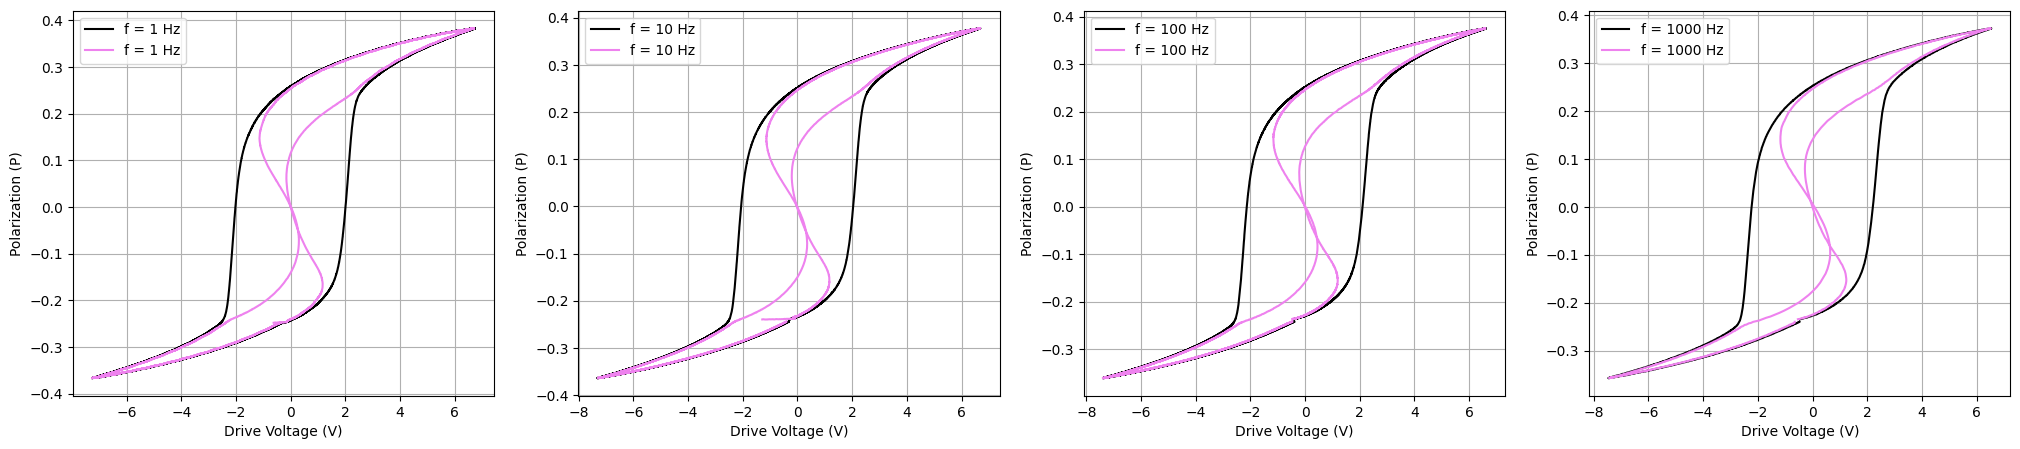

In [8]:
# this block of code estimate the rho value from the proposed method .. but turned out to be not a correct method to find rho value
R = []
C = []
V_rm_R = []
V_rm_cap = []
Vc = []
Pr = []
plt.figure(figsize=(25,5))
for i in range(len(f_data)):
    plt.subplot(1,4,i+1); plt.plot(V_crt[i], P_crt[i], label = f"f = {f_data[i]} Hz", color = "black")
    Vc1, Vc2, Pr1, Pr2 = find_Ec_Pr(P_crt[i], V_crt[i])
    Vc.append((abs(Vc1)+abs(Vc2))/2)
    Pr.append((abs(Pr1)+abs(Pr2))/2)
    print("Vc = ", Vc[i], "Pr = ", Pr[i])
    print(find_R(V_crt[i],I_flt[i],P_crt[i]))
    R.append(find_R(V_crt[i],I_flt[i],P_crt[i]))
    C.append(1/(2*np.pi*f_data[i]*R[i]))
    V_rm_R.append(V_crt[i] - R[i]*I_flt[i])
    # V_rm_cap.append(V_crt[i] - P_crt[i]/C[i])
    plt.subplot(1,4,i+1); plt.plot(V_rm_R[i], P_crt[i], label = f"f = {f_data[i]} Hz", color = "violet")
    #plt.subplot(1,4,i+1); plt.plot(V_rm_cap[i], P_crt[i], label = f"f = {f_data[i]} Hz", color = "cyan")
    plt.grid()
    plt.xlabel("Drive Voltage (V)")
    plt.ylabel("Polarization (P)")
    plt.legend()

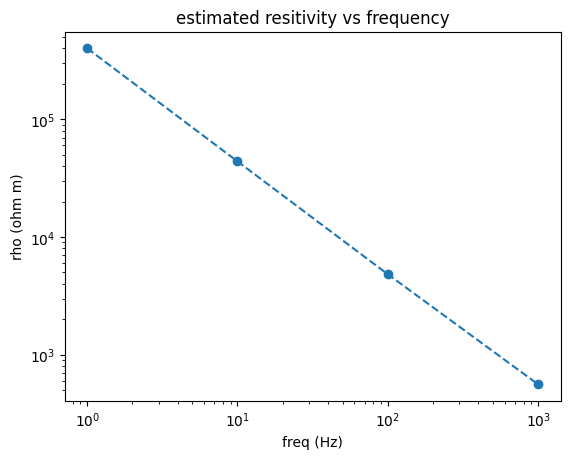

In [9]:
# #Debugging
# #assuming the 
# print(C)
# plt.semilogx(f_data, np.log10(R), "--o")
plt.title("estimated resitivity vs frequency")
plt.xlabel("freq (Hz)")
plt.ylabel("rho (ohm m)")
plt.loglog(f_data, np.array(R)*Af/tf, "--o")
# assuming what we estimated as capacitance
# C = 1/(2*np.pi*np.array(f_data)*np.array(R))

In [10]:
print(np.array(R)*Af/tf,)

[401210.92208967  43899.52854531   4825.82248531    559.89714567]


2.20755 2.01295 2.32e-07 0.000148263
1314.5895116563413


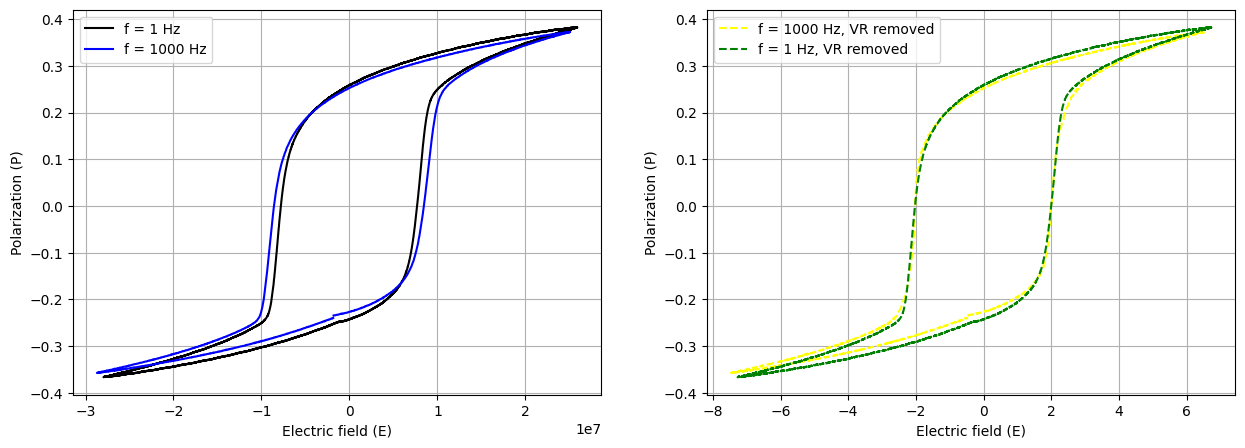

In [11]:
# so to estimate R let's try a different strategy
# lets take 1 Hz, signal and 1000 Hz signal
# lets 1 Hz be my quasi static signal
# and find out how much times current has to be reduced from the drive voltage to overlap hysteresis
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.plot(E[0], P_crt[0], label = f"f = {f_data[0]} Hz", color = "black")
plt.subplot(1,2,1); plt.plot(E[3], P_crt[3], label = f"f = {f_data[3]} Hz", color = "blue")
plt.xlabel("Electric field (E)")
plt.ylabel("Polarization (P)")
plt.legend()
plt.grid()

k1 = 0
k2 = 3

idx1 = np.where(np.abs(P_crt[k1][0:int(len(P_crt[k1])/2)]) == np.min(np.abs(P_crt[k1][0:int(len(P_crt[k1])/2)])))
I_P0 = I[k1][idx1[0][0]]
idx1 = np.where(np.abs(P_crt[k2][0:int(len(P_crt[k2])/2)]) == np.min(np.abs(P_crt[k2][0:int(len(P_crt[k2])/2)])))
I_P3 = I[k2][idx1[0][0]]

print(Vc[k2], Vc[k1], I_P0, I_P3)
Rest = (Vc[k2] - Vc[k1])/(I_P3 - I_P0)
print(Rest)

plt.subplot(1,2,2); plt.plot(V_crt[k2] - np.array(I[k2])*Rest, P_crt[k2], '--' ,  label = f"f = {f_data[k2]} Hz, VR removed", color = "yellow")
plt.subplot(1,2,2); plt.plot(V_crt[k1] - np.array(I[k1])*Rest, P_crt[k1], '--' ,  label = f"f = {f_data[k1]} Hz, VR removed", color = "green")
plt.xlabel("Electric field (E)")
plt.ylabel("Polarization (P)")
plt.legend()
plt.grid()

In [12]:
# Pr_s = Pr[0]
# Ec_s = Vc[0]/2/tf
# alpha = -3*np.sqrt(3)*Ec_s/(4*Pr_s)
# beta = 3*np.sqrt(3)*Ec_s/(8*Pr_s**3)
# print(Pr_s, Ec_s, alpha, beta)

# def df_dp(P,E):
#     return (2*alpha*P + 4*beta*P**3 - E)

# def triangular_wave(frequency, dt):
#     T = 1 / frequency  # Period of the wave
#     t = np.arange(0, T, dt)  # Time values
#     # Generate triangular wave: 0 → +max → -max → 0
#     y = 7*(2 * np.abs(2 * (t / T - np.floor(0.5 + t / T))) - 1)
#     return t, y

# # since the sampling points is a problem we create our own drive signal
# P_fit = []
# plt.figure(figsize=(25,5))
# for f in range(len(f_data)):
#     P_fit_f = [P[f][0]]
#     dt_s = 1/f_data[f]/10
#     tdrive, Vdrive = triangular_wave(f_data[f], dt_s)
#     for i in range(1,len(tdrive)):
#         P_fit_f.append(P_fit_f[i-1] - dt_s*tf/Rest/Af*df_dp(P_fit_f[i-1],Vdrive[i]/tf))
#     P_fit.append(P_fit_f)
#     plt.subplot(1,4,f+1)
#     plt.plot(V_crt[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
#     plt.legend()
#     plt.grid()

# #since the sampling points is a problem we create our own drive signal
# P_fit = []
# Rest = 10
# plt.figure(figsize=(25,5))
# for f in range(len(f_data)):
#     P_fit_f = [P_crt[f][0]]
#     for i in range(1,len(time[f])):
#         P_fit_f.append(P_fit_f[i-1] - dt[f]*tf/(Rest*Af)*df_dp(P_fit_f[i-1],E[f][i]))
#     P_fit.append(P_fit_f)
#     plt.subplot(1,4,f+1)
#     plt.plot(V_crt[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
#     plt.plot(V_drive[f], P_fit_f, label = f"fit", color = "red")
#     plt.legend()
#     plt.grid()

# print(f"a = {alpha}, b = {beta}, R = {Rest}")


In [13]:
Pr_s = Pr[0]
Ec_s = Vc[0]/tf
alpha = -3*np.sqrt(3)*Ec_s/(4*Pr_s)
beta = 3*np.sqrt(3)*Ec_s/(8*Pr_s**3)
rho = Rest*Af/tf
print(Pr_s, Ec_s, alpha, beta, rho)
# plt.plot(t, P_fit)

0.248307745 7742115.384615385 -40503379.80058125 328458675.2327503 50.561135063705436


In [14]:
t = []
Edrive = []
P_fit = []
alpha = -4.05e7
beta = 3.28e8
rho = 15.56
plt.figure(figsize=(25,5))
for f in range(len(f_data)):
    ts, Edrives = sin_wave(7/tf, f_data[f], 10e-9)
    t.append(ts)
    Edrive.append(Edrives)
    P_fits = TDGL(ts, P[0], Edrives, alpha, beta, rho)
    P_fit.append(P_fits)

KeyboardInterrupt: 

<Figure size 2500x500 with 0 Axes>

C:\Users\manik\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\manik\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


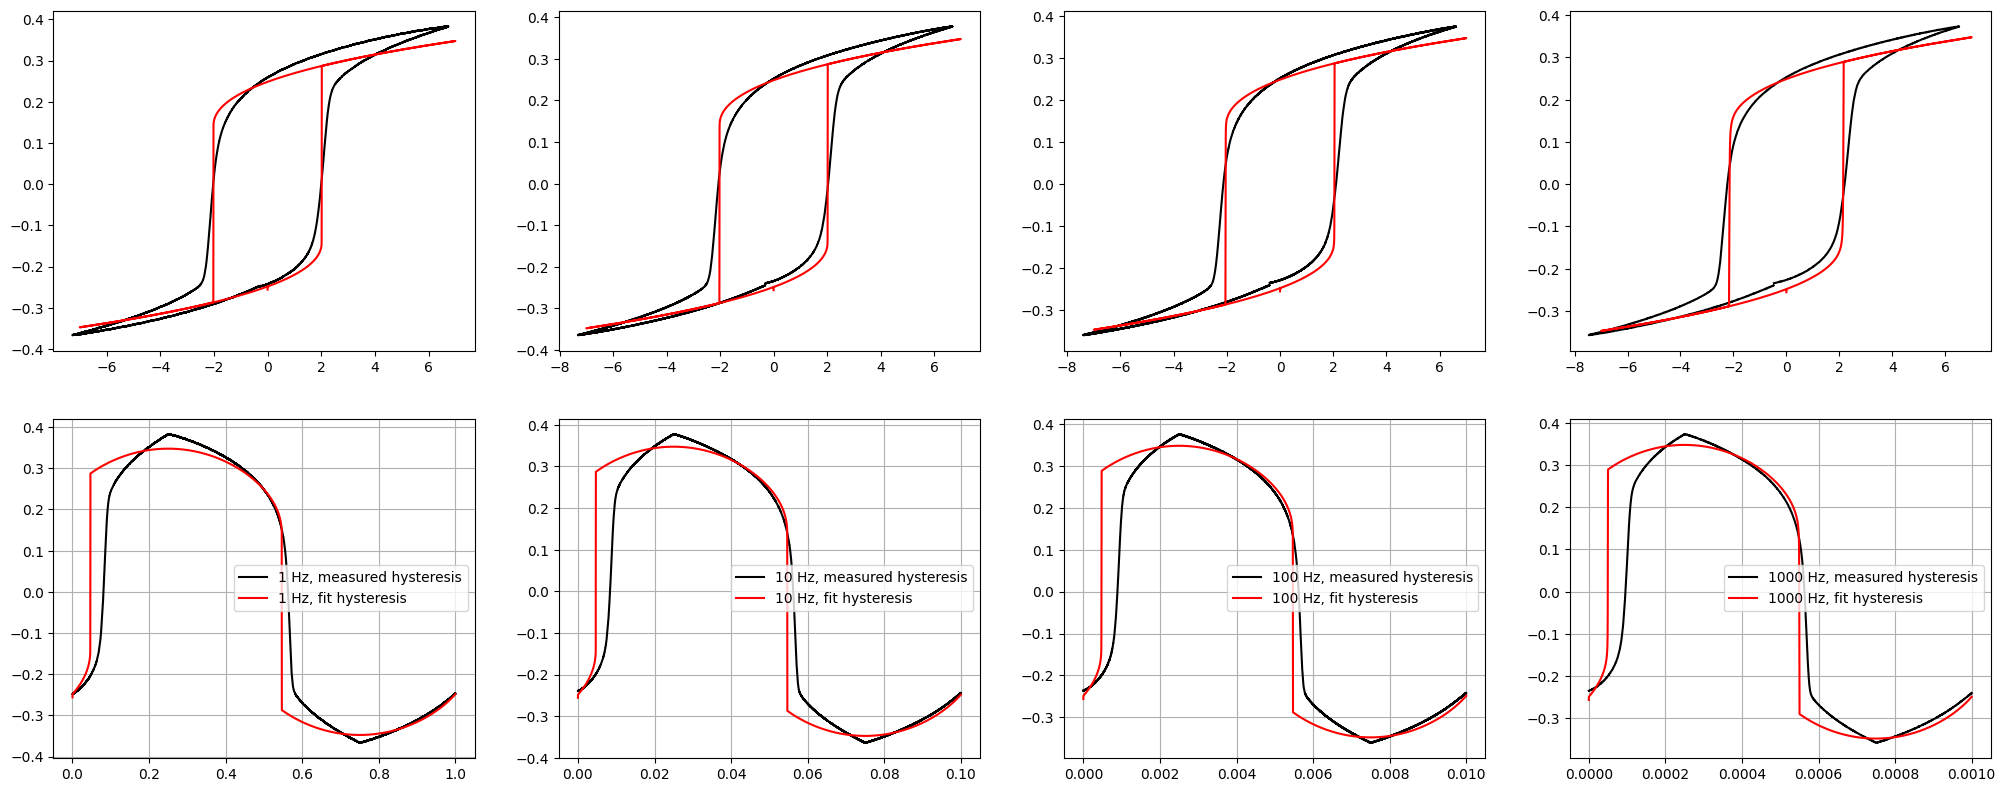

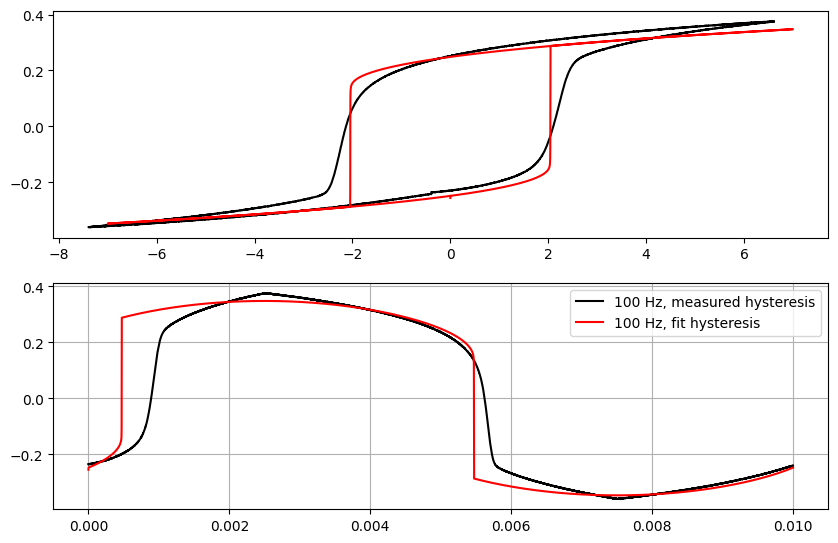

In [ ]:
plt.figure(figsize=(25,15))
for f in range(len(f_data)):
    plt.subplot(3,4,f+1)
    plt.plot(V_crt[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
    plt.plot(Edrive[f]*tf, P_fit[f], label = f"{f_data[f]} Hz, fit hysteresis", color = "red")
    plt.subplot(3,4,4+f+1)
    plt.plot(time[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
    plt.subplot(3,4,4+f+1)
    plt.plot(t[f], P_fit[f], label = f"{f_data[f]} Hz, fit hysteresis", color = "red")
    plt.legend()
    plt.grid()

f = 2
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(V_crt[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
plt.plot(Edrive[f]*tf, P_fit[f], label = f"{f_data[f]} Hz, fit hysteresis", color = "red")
plt.subplot(3,1,2)
plt.plot(time[f], P_crt[f], label = f"{f_data[f]} Hz, measured hysteresis", color = "black")
# plt.subplot(3,1,3)
plt.plot(t[f], P_fit[f], label = f"{f_data[f]} Hz, fit hysteresis", color = "red")
plt.legend()
plt.grid()

Kramers Time Calculation

In [62]:
# rho = 500 #just for testing


alpha = -4.05e7
beta = 3.28e8
rho = 21

def calculate_kramer_curve(sigma,bias):   
    R_F = rho*tf/Af # Resistance of the sample
    del_F = 1e6 #delta_U(bias)
    Dext = sigma**2/(2*R_F*del_F*tf*Af)
    val = findPAPC(bias)
    P_A = val[0]
    P_C = val[1]
    tau_k = 2*np.pi*rho/(np.sqrt(np.abs(f_dd(P_A)*f_dd(P_C))))*np.exp(delta_U(bias)/Dext)
    return tau_k

def f_dd(P):
    return 2*alpha + 12*beta*P**2

def findPAPC(bias):
    xminL = sc.optimize.fsolve(soldU_dx,-0.4,args=(bias))
    xmax = sc.optimize.fsolve(soldU_dx,0,args=(bias))
    xminR = sc.optimize.fsolve(soldU_dx,0.4,args=(bias))
    return np.array([xminL, xmax, xminR])

def U(P,bias):
    return (alpha*P**2 +beta*P**4-P*bias/tf)

def delta_U(bias):
    val = findPAPC(bias)
    return U(val[1],bias)-U(val[0],bias)

def soldU_dx(P,bias):
    return 2*alpha*P +4*beta*P**3 - bias/tf


[[-0.20846202]
 [-0.0664895 ]
 [ 0.27495153]]
[90044447.19278583]
[-63599518.26341794]
rho estim from p plot =  [21.67943791]


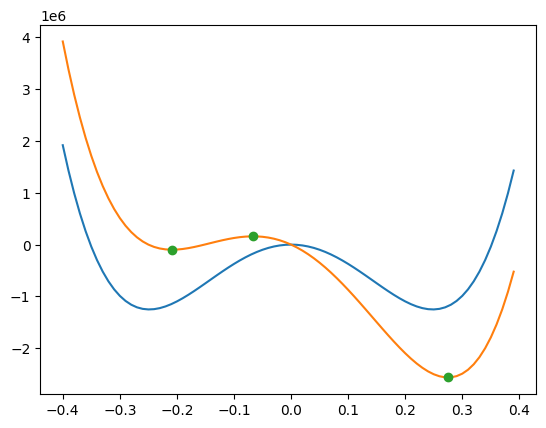

In [63]:
Prange = np.arange(-0.4, 0.4, 0.01)
plt.plot(Prange, U(Prange, 0))
plt.plot(Prange, U(Prange, 1.3))
P_minmax = findPAPC(1.3)
plt.plot(P_minmax, U(P_minmax, 1.3), "o")
# plt.plot(Prange, U(Prange, 1.4))
# plt.plot(Prange, U(Prange, 1.5))
print(P_minmax)
print(f_dd(P_minmax[0]))
print(f_dd(P_minmax[1]))
print("rho estim from p plot = ", (1.8e-6*np.sqrt(abs(f_dd(P_minmax[0])*f_dd(P_minmax[1])))/(2*np.pi)))


In [64]:
sd = [0.3,0.35,0.4,0.45,0.5,0.55]
kt_1_3 = [0,0,0,0.000153793, 5.33E-05, 3.22E-05]
kt_1_4 = [0, 0, 9.80E-05,3.97E-05,2.85E-05,2.04E-05]
kt_1_5 = [0.000206122, 5.31E-05, 2.48E-05, 1.93E-05, 1.55E-05, 1.27E-05]

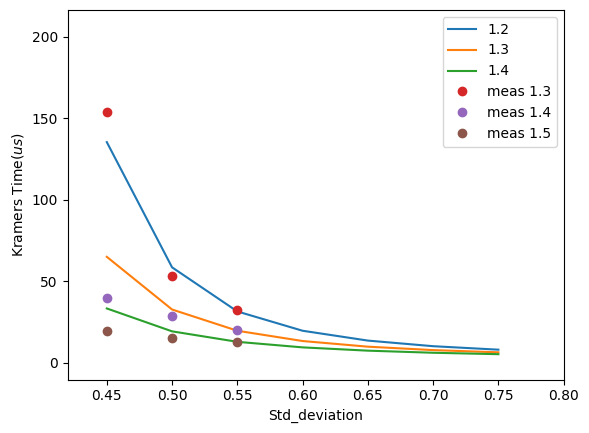

In [65]:
sigma_list = np.arange(0.45,0.8,0.05) # Voltage variance
t0 = calculate_kramer_curve(sigma_list, 0)
t1 = calculate_kramer_curve(sigma_list, 1.2)
t2 = calculate_kramer_curve(sigma_list, 1.3)
t3 = calculate_kramer_curve(sigma_list, 1.4)
# plt.plot(sigma_list,t0*1e6, label = "0")
plt.plot(sigma_list,t1*1e6, label = "1.2")
plt.plot(sigma_list,t2*1e6, label = "1.3")
plt.plot(sigma_list,t3*1e6, label = "1.4")

plt.plot(sd, np.array(kt_1_3)*1e6,"o", label = "meas 1.3")
plt.plot(sd, np.array(kt_1_4)*1e6,"o", label = "meas 1.4")
plt.plot(sd, np.array(kt_1_5)*1e6,"o", label = "meas 1.5")

plt.xlim([0.42,0.8])
plt.xlabel("Std_deviation")
plt.ylabel("Kramers Time($us$)")
plt.legend()
plt.show()

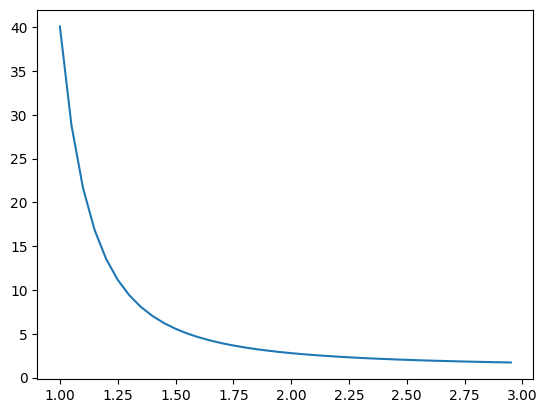

In [66]:
sigma_list = np.arange(1,3,0.05) # Voltage variance
t0 = calculate_kramer_curve(sigma_list, 0)
plt.plot(sigma_list,t0*1e6, label = "0")